In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization to /tmp/pip-req-build-vb1c7avi
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization /tmp/pip-req-build-vb1c7avi
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 62 kB 512 kB/s 
     |████████████████████████████████| 298 kB 39.0 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=144999 sha256=94556d5a934b1d8ec19165c174dee1af56bd8974e386e56c99c6662e4c79ceda
  Stored in directory: /tmp/pip-ephem-wheel-cache-y5fen8yg/wheels/eb/7f/26/4a3835d3d83e17ac1d9bed33d09ecdd6dd423759b38e69c270
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=5032172162760e39890ec4eeca08dc914eeb46c88460909d009d408687c11ce0
  Stored in directory

In [2]:
!pip3 install cma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 249 kB 21.5 MB/s 


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from benchmark.bbobbenchmarks import F10, F11, F12, F13, F14, F15, F16, F21

In [15]:
dim = 2
lb, ub = -5, 5

space = RealSpace([lb, ub]) * dim

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

doe_sizes = (5, 10, 15, 20)
max_FEs = 50
verbose = False

n_samples = 1000

max_cma_iter = 10

PLOT_SIZE = (20, 10)

In [39]:
opt_color, found_color, initial_color = "green", "red", "blue"


def plot(points, colors, ax=plt, outline=False, marker='o'):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker)
  
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["initial_points"] is not None:
    plot(result["initial_points"], ["blue"] * result["initial_points"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, marker='s')

In [17]:
def make_optimizer(obj_func, doe, random_seed=1):
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim,
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1, 
        random_seed=random_seed
    )
    
def regret_function(obj_func, doe_size):
    def func(X):
        doe = np.split(X, doe_size)
        opt = make_optimizer(obj_func, doe)
        _, value, _ = opt.run()
        return value - obj_func.getfopt()
    return func

## Experiments

In [18]:
sigma0 = ub / 3 # the optimum is expected to lie within x0 +- 3 * sigma0

def cma_es_experiment(obj_function, doe_size, bo_seed=1, cma_seed=1111):
  regret_func = regret_function(obj_function, doe_size)
  doe_flattened, es = cma.fmin2(regret_func, np.zeros(doe_size * dim), sigma0, {'maxiter': max_cma_iter, 'seed': cma_seed})
  doe = np.split(doe_flattened, doe_size)
  opt = make_optimizer(obj_function, np.split(es.best.x, doe_size), bo_seed)
  x, value, _ = opt.run()
  samples = space.sample(n_samples)
  values = obj_function(samples)
  regret = value - obj_function.getfopt()
  print(f'Regret is: {regret}, Found x: {x}, Found f: {value}, Optimal f: {obj_function.getfopt()}, Optimum x: {obj_function._xopt}')
  plot_result(obj_func, samples, values, {"initial_points": np.array(doe), "regret": regret, "found_x": x}, plt.gca())
  return doe

In [38]:
def plot_test_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  plot(result["initial_points"], ["blue"] * len(result["initial_points"]), ax=ax, marker='^')
  plot(result["removed_point"], ["blue"], ax=ax, marker='x')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["found_x"]], [opt_color, found_color], ax=ax, marker='s')

def plot_test(func, samples, values, results):
    fig, axs = plt.subplots(1, len(results))
    fig.suptitle("Objective function " + func.__class__.__name__, fontsize=8)
    for (result, ax) in zip(results, axs):
        plot_test_result(func, samples, values, result, ax)
    plt.show()

In [36]:
def test_doe(obj_func, doe):
  result = []
  for i in range(len(doe)):
    removed_point = doe[i]
    reduced_doe = doe[:i] + doe[i + 1:]
    opt = make_optimizer(obj_func, reduced_doe)
    x, value, _ = opt.run()
    samples = space.sample(n_samples)
    values = obj_func(samples)
    regret = value - obj_func.getfopt()
    print(f'Regret is: {regret} without {removed_point}')
    result.append({"removed_point": removed_point, "regret": regret, "found_x": x, "found_f": value, "initial_points": reduced_doe})
  samples = space.sample(n_samples)
  values = obj_func(samples)
  plot_test(obj_func, samples, values, result)
  return result, samples, values

### F21


(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1111, Wed Oct 19 05:57:55 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.073741363913101e-01 1.0e+00 1.59e+00  2e+00  2e+00 1:10.7
    2     18 2.963351018547655e-02 1.2e+00 1.65e+00  2e+00  2e+00 2:28.9
    3     27 4.619457316898945e-03 1.4e+00 1.76e+00  2e+00  2e+00 3:43.0
    4     36 2.630430606771483e-04 1.5e+00 1.69e+00  2e+00  2e+00 4:52.5
    5     45 4.066289290701519e-02 1.6e+00 1.61e+00  1e+00  2e+00 6:01.0
    6     54 1.228147426388659e-04 1.6e+00 1.59e+00  1e+00  2e+00 7:23.0
    7     63 1.047167505014102e-03 1.8e+00 1.43e+00  1e+00  2e+00 8:31.5
    8     72 1.548052239783715e-04 1.8e+00 1.37e+00  1e+00  2e+00 9:41.2
    9     81 1.153098163705124e-03 2.1e+00 1.33e+00  1e+00  1e+00 10:51.1
   10     90 3.770153327309345e-07 2.1e+00 1.36e+00  1e+00  2e+00 12:03.1
termination on maxiter=10 (Wed Oct 19 06:10:10 2022)
final/bestever f-value = 4.946838e-01 3.770153e-07
incu

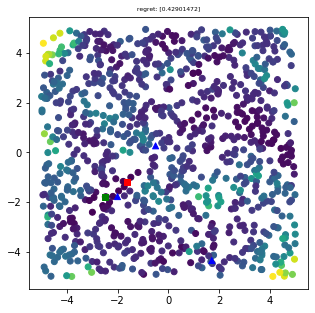

In [23]:
obj_func = F21(1)
doe_size = 3

plt.rcParams["figure.figsize"] = (5, 5)
doe3 = cma_es_experiment(obj_func, doe_size)

Regret is: [0.00356294] without [ 1.71142173 -4.34234261]
Regret is: [0.42278231] without [-0.50388799  0.26674062]
Regret is: [0.00023171] without [-2.00442749 -1.77252565]


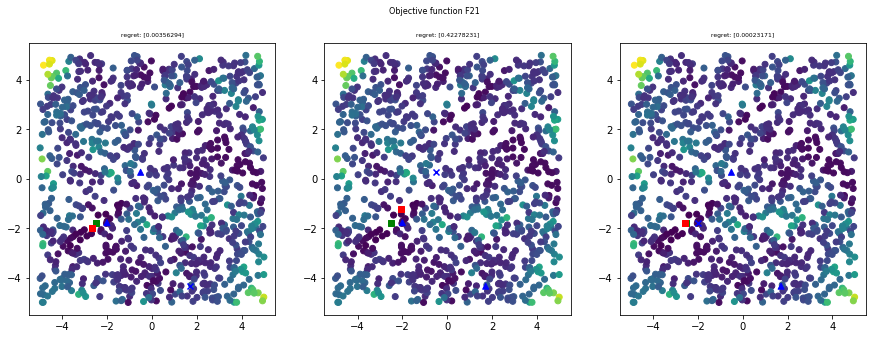

In [40]:
plt.rcParams["figure.figsize"] = (15, 5)
result3 = test_doe(obj_func, doe3) # remove each point from the doe and compute error

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1111, Wed Oct 19 06:18:20 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 3.390260064151107e-05 1.0e+00 1.57e+00  2e+00  2e+00 1:21.1
    2     20 2.750378919813556e-05 1.2e+00 1.57e+00  2e+00  2e+00 2:48.3
    3     30 2.796118509422740e-04 1.2e+00 1.51e+00  1e+00  2e+00 4:08.4
    4     40 1.348125142826007e-04 1.3e+00 1.49e+00  1e+00  2e+00 5:21.9
    5     50 1.562391808818120e-06 1.4e+00 1.50e+00  1e+00  2e+00 6:48.7
    6     60 1.496708074455455e-05 1.5e+00 1.60e+00  2e+00  2e+00 8:09.7
    7     70 8.641314421709012e-04 1.6e+00 1.79e+00  2e+00  2e+00 9:31.0
    8     80 1.431944051120126e-03 1.6e+00 1.75e+00  2e+00  2e+00 10:56.3
    9     90 1.264146546660072e-04 1.6e+00 1.74e+00  2e+00  2e+00 12:15.0
   10    100 1.726106260882432e-02 1.6e+00 1.64e+00  2e+00  2e+00 13:34.2
termination on maxiter=10 (Wed Oct 19 06:32:03 2022)
final/bestever f-value = 2.299601e-04 1.562392e-06
i

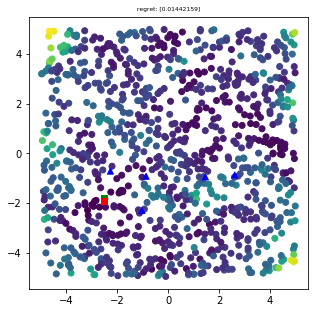

In [41]:
doe_size = 5

plt.rcParams["figure.figsize"] = (5, 5)
doe5 = cma_es_experiment(obj_func, doe_size)

Regret is: [8.49496991e-06] without [-0.86092344 -0.92576086]
Regret is: [0.06883743] without [ 1.46690891 -0.95206345]
Regret is: [0.00020413] without [ 2.61882894 -0.87307642]
Regret is: [0.12518197] without [-2.2618488  -0.71858661]
Regret is: [0.06481087] without [-1.02078024 -2.30453277]


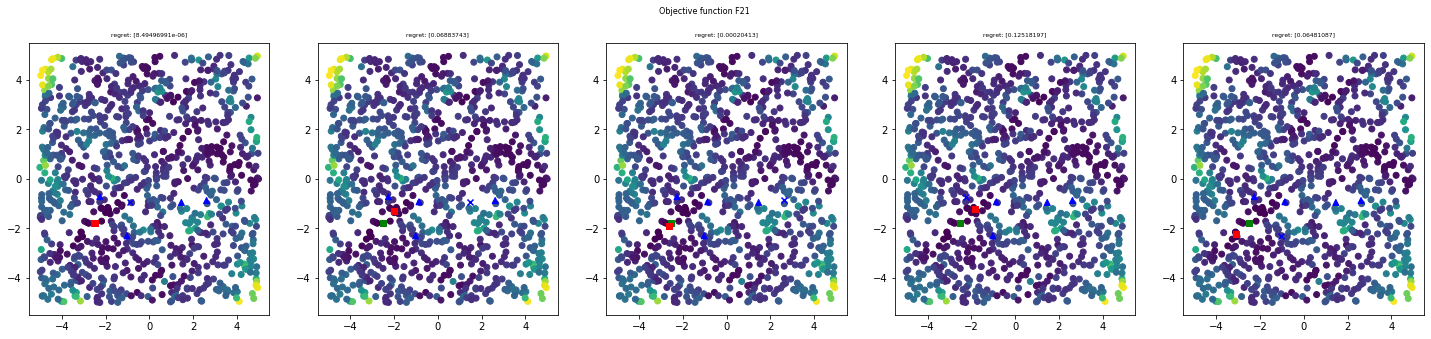

In [42]:
plt.rcParams["figure.figsize"] = (25, 5)
result5 = test_doe(obj_func, doe5)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 20 (seed=1111, Wed Oct 19 07:06:32 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 4.340890110654527e-04 1.0e+00 1.56e+00  2e+00  2e+00 1:30.6
    2     24 3.291793493787054e-05 1.1e+00 1.50e+00  1e+00  2e+00 2:59.3
    3     36 6.950621560974923e-06 1.1e+00 1.42e+00  1e+00  1e+00 4:24.6
    4     48 2.897878756428440e-03 1.2e+00 1.33e+00  1e+00  1e+00 5:56.1
    5     60 5.348418667949772e-07 1.2e+00 1.26e+00  1e+00  1e+00 7:23.1
    6     72 1.121662165743942e-04 1.2e+00 1.22e+00  1e+00  1e+00 8:43.3
    7     84 1.950919185702560e-04 1.2e+00 1.23e+00  1e+00  1e+00 10:15.9
    8     96 1.448254181468656e-06 1.3e+00 1.22e+00  1e+00  1e+00 11:41.4
    9    108 6.467252404718238e-06 1.3e+00 1.21e+00  1e+00  1e+00 13:10.7
   10    120 6.409053284528454e-06 1.3e+00 1.22e+00  1e+00  1e+00 14:34.0
termination on maxiter=10 (Wed Oct 19 07:21:14 2022)
final/bestever f-value = 9.890782e-04 5.348419e-07


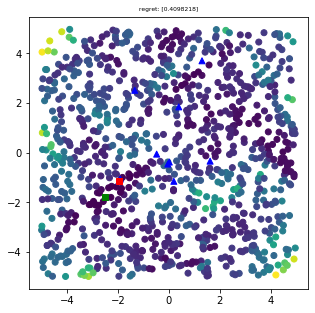

In [45]:
doe_size = 10

plt.rcParams["figure.figsize"] = (5, 5)
doe10 = cma_es_experiment(obj_func, doe_size)

Regret is: [0.00295859] without [ 1.61899065 -0.33825718]
Regret is: [1.32004332e-06] without [1.30133787 3.705842  ]
Regret is: [0.00043918] without [-1.91188334 -1.06072791]
Regret is: [0.00121338] without [-0.0419692  -0.45575589]
Regret is: [0.00155272] without [ 0.19426533 -1.14959901]
Regret is: [0.15148839] without [0.38818777 1.84844488]
Regret is: [0.4098218] without [ 0.01679018 -0.37489701]
Regret is: [0.08535375] without [-1.95993377 -1.15504484]
Regret is: [0.07588431] without [-0.47945006 -0.05463508]
Regret is: [0.00710731] without [-1.34110728  2.51688772]


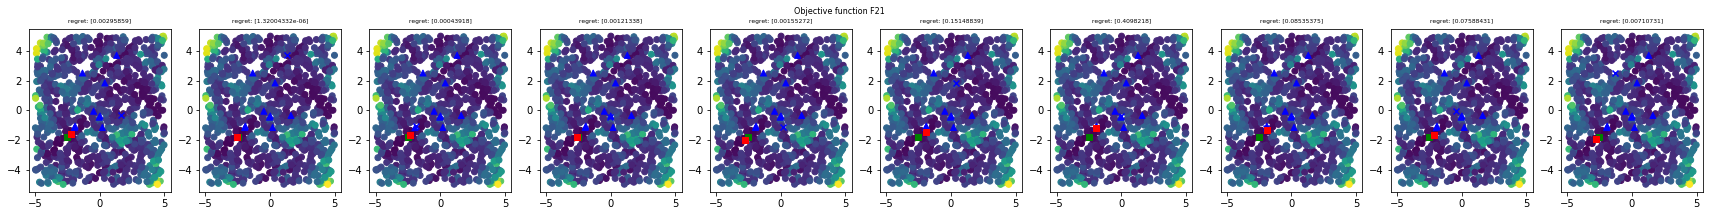

In [46]:
plt.rcParams["figure.figsize"] = (30, 3)
result10 = test_doe(obj_func, doe10)